Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
!pip install Augmentor==0.2.10

In [2]:
import numpy as np
import pandas as pd
import os
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, InputLayer, BatchNormalization
import matplotlib.pyplot as plt
import PIL
from sklearn.preprocessing import LabelEncoder
import Augmentor
import shutil

%matplotlib inline

### Importing Skin Cancer Data

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Google Drive and Google Colab

# Download and import images and labels
from google.colab import drive
drive.mount('/content/drive/')

# Path to the extracted directory
extracted_dir = '/content/drive/MyDrive/AIML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration'

Mounted at /content/drive/


In [5]:
# Local Drive and Jupyter notebook
# Import images and labels
#extracted_dir = 'CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration'

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(extracted_dir) / "Train"
data_dir_test = pathlib.Path(extracted_dir) /  "Test"

print(f"Extracted data to: {extracted_dir}")
print(f"Extracted Train data to: {data_dir_train}")
print(f"Extracted Test data to: {data_dir_test}")

Extracted data to: /content/drive/MyDrive/AIML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration
Extracted Train data to: /content/drive/MyDrive/AIML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train
Extracted Test data to: /content/drive/MyDrive/AIML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [7]:
# Count of Train and Test set
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [8]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
# Set random seed for reproducibility =  123
tf.random.set_seed(123)

#### Use 80% of the images for training, and 20% for validation.

In [10]:
# Remove the output folders that were generated during augmentation auto image generation technique
def remove_output_subfolders(parent_dir):
  for root, dirs, files in os.walk(parent_dir):
    for dir_name in dirs:
      if dir_name == 'output':
        output_path = pathlib.Path(root) / dir_name
        try:
          shutil.rmtree(output_path)
        except OSError as e:
          print(f"Error removing folder {output_path}: {e}")
remove_output_subfolders(extracted_dir)

In [11]:
# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,  # Path to the training dataset
    image_size = (img_height, img_width),     # Resize all images to 180*180
    batch_size = None,           # Number of images per batch
    label_mode = "int",         # Labels are integers corresponding to subdirectory names
    seed = 123,
    color_mode = "rgb"
)

# Load validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,    # Path to the validation dataset
    image_size = (img_height, img_width),     # Resize all images to 180*180
    batch_size = None,        # Number of images per batch
    label_mode = "int",       # Labels are integers corresponding to subdirectory names
    seed = 123,
    color_mode = "rgb"
)

# View one batch of images and labels
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Found 2239 files belonging to 9 classes.
Found 118 files belonging to 9 classes.
Images shape: (180, 180, 3)
Labels shape: ()


In [13]:
# Separate images and labels
x_train = []
y_train = []
x_test = []
y_test = []

# Translating to X and y
for images, labels in train_dataset:
    x_train.append(images.numpy().astype('uint8'))
    y_train.append(labels.numpy())

for images, labels in val_dataset:
    x_test.append(images.numpy().astype('uint8'))
    y_test.append(labels.numpy())

# Convert lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (2239, 180, 180, 3)
y_train shape: (2239,)
x_test shape: (118, 180, 180, 3)
y_test shape: (118,)


In [14]:
# List out all the classes of skin cancer and store them in a list.
num_classes = len(np.unique(y_train))
print(num_classes)
np.unique(y_train)
class_names = train_dataset.class_names
print(class_names)
print(x_train[1,::])

9
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
[[[138 103  90]
  [138  96  91]
  [134  96  90]
  ...
  [145 114 111]
  [139 107 107]
  [134 100  98]]

 [[136  96  90]
  [136  86  86]
  [131  91  84]
  ...
  [140 110 110]
  [137 105 108]
  [140 105 104]]

 [[137  96  99]
  [136  94  88]
  [132  88  80]
  ...
  [147 122 124]
  [143 114 119]
  [139 105 104]]

 ...

 [[141 101 100]
  [143 107 106]
  [150 114 117]
  ...
  [131  90  89]
  [135  96  94]
  [128  90  85]]

 [[141  95  98]
  [151 114 117]
  [153 119 121]
  ...
  [131  92  90]
  [135  97  96]
  [130  93  90]]

 [[140  99 103]
  [151 113 124]
  [150 114 117]
  ...
  [125  84  85]
  [131  95  93]
  [131  97  95]]]


### Visualize the data

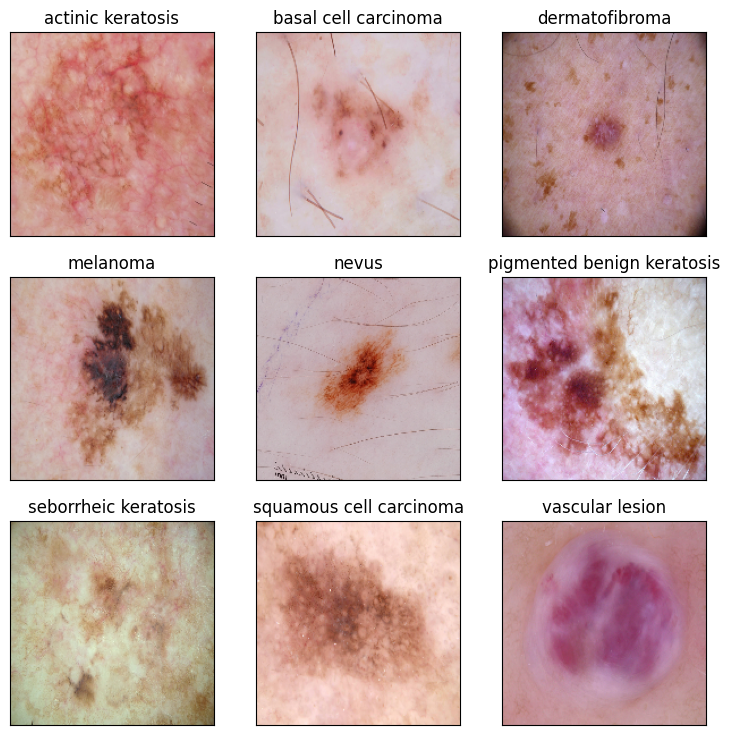

In [15]:
# Code to visualize one instance of all the nine classes present in the dataset

fig = plt.figure(figsize=(9,9))
for i in range(num_classes):
    ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = (features_idx[img_num,::])
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [16]:
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [17]:
print(y_train[:5])
print(y_test[:5])
print(x_train.shape[1:])

[[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(180, 180, 3)


### Base model 1

#### Model Building & training

In [18]:
# Number of epochs = 20
epochs = 20

# Pipeline of the layers
model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(x_train.shape[1:])))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compiling the model
model.compile(optimizer='Adam', loss='categorical_crossentropy' , metrics=['accuracy'])

In [20]:
# Train the model
model1 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.2161 - loss: 2.1993 - val_accuracy: 0.2034 - val_loss: 2.1805
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.3676 - loss: 1.7922 - val_accuracy: 0.2627 - val_loss: 2.0522
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4372 - loss: 1.6031 - val_accuracy: 0.3220 - val_loss: 2.0255
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4548 - loss: 1.5392 - val_accuracy: 0.3305 - val_loss: 2.0420
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4917 - loss: 1.4702 - val_accuracy: 0.3390 - val_loss: 2.2355
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5255 - loss: 1.4052 - val_accuracy: 0.3220 - val_loss: 2.2810
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5127 - loss: 1.3451 - val_accuracy: 0.3136 - val_loss: 2.2308
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5314 - loss: 1.3401 - val_accuracy: 0.3390 -

#### Model Evaluation

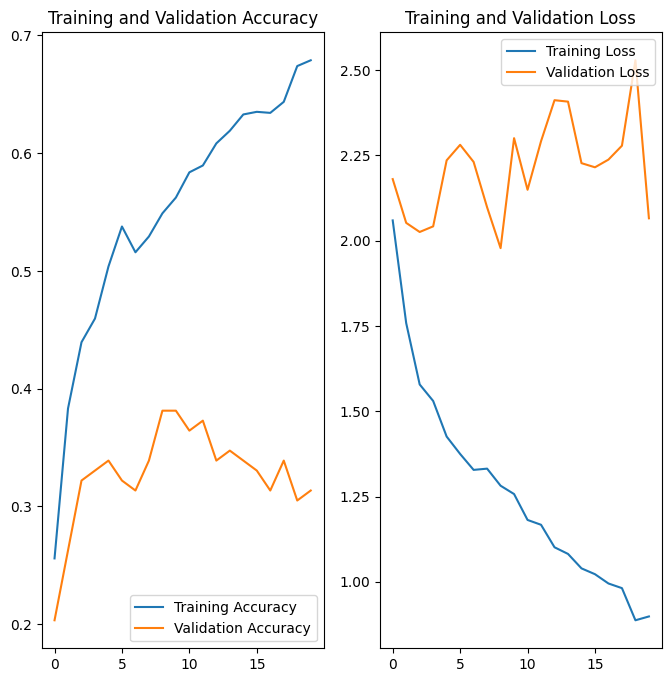

In [21]:
# Evaluate model performance

acc = model1.history['accuracy']
val_acc = model1.history['val_accuracy']
loss = model1.history['loss']
val_loss = model1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

1. The model's training accuracy shows a steady increase of upto 60%, while validation accuracy remains consistently around 35%.

2. A medium training accuracy suggests the model has not effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability.

3. These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.

### Augmentation strategy

In [22]:
# Create an ImageDataGenerator Instance:

datagen = ImageDataGenerator(
    rotation_range=20,          # Rotate images by up to 20 degrees
    width_shift_range=0.2,      # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,     # Shift images vertically by up to 20% of the height
    shear_range=0.2,            # Apply shear transformations
    zoom_range=0.2,             # Zoom in or out by up to 20%
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill in missing pixels using the nearest pixel
)

In [23]:
# Apply Augmentation to Training Data
train_gen = datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size
)

### Model 2 with augmentation image generator

#### Model Building & training

In [24]:
model2_gen = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=(x_test, y_test),  # No augmentation for validation data
    shuffle=True
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - accuracy: 0.4290 - loss: 1.8649 - val_accuracy: 0.3559 - val_loss: 2.1137
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 232ms/step - accuracy: 0.4893 - loss: 1.4600 - val_accuracy: 0.3559 - val_loss: 2.2104
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 231ms/step - accuracy: 0.5101 - loss: 1.3317 - val_accuracy: 0.3220 - val_loss: 2.3712
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 231ms/step - accuracy: 0.5394 - loss: 1.3161 - val_accuracy: 0.3136 - val_loss: 2.0251
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.5091 - loss: 1.4299 - val_accuracy: 0.3390 - val_loss: 2.3484
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.5204 - loss: 1.3424 - val_accuracy: 0.3644 - val_loss: 2.0413
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - accuracy: 0.5156 - loss: 1.3841 - val_accuracy: 0.3729 - val_loss: 2.0810
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.5210 - loss: 1.3401 - val_accuracy: 0.364

#### Model Evaluation

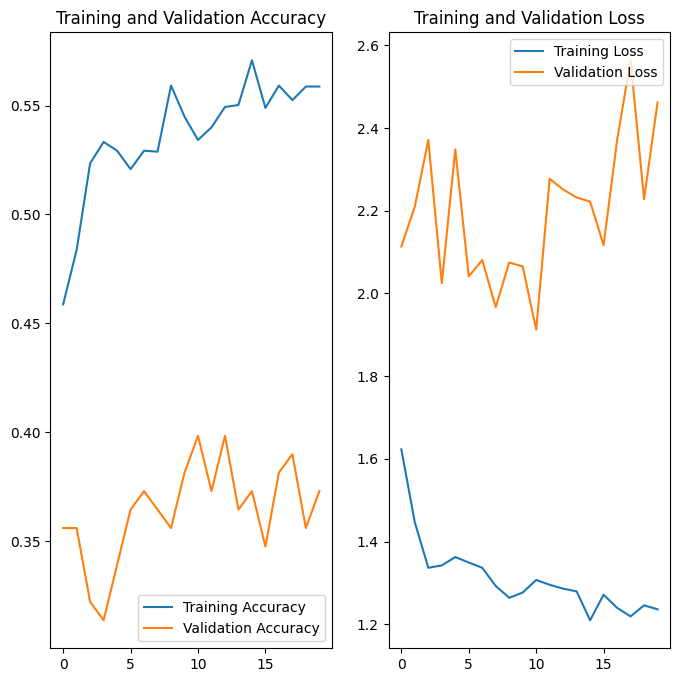

In [25]:
# Evaluate model_gen performance
acc = model2_gen.history['accuracy']
val_acc = model2_gen.history['val_accuracy']
loss = model2_gen.history['loss']
val_loss = model2_gen.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

1. By leveraging augmented data, overfitting addressed to a very little extent.

2. The training and validation accuracy of the aforementioned model fall within almost similar range.

3. Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.

### Class imbalance rectification using Augmentor

In [26]:
# Calculate Class Frequencies
from collections import Counter

class_frequencies = Counter(np.argmax(y_train, axis=1))  # Assuming y_train is one-hot encoded

for class_index, frequency in class_frequencies.items():
    print(f"Class {class_names[class_index]}: {frequency} samples")

Class nevus: 357 samples
Class basal cell carcinoma: 376 samples
Class melanoma: 438 samples
Class pigmented benign keratosis: 462 samples
Class vascular lesion: 139 samples
Class seborrheic keratosis: 77 samples
Class actinic keratosis: 114 samples
Class dermatofibroma: 95 samples
Class squamous cell carcinoma: 181 samples


In [27]:
# Identify the Class with the Least Samples
least_frequent_class = min(class_frequencies, key=class_frequencies.get)
print(f"\nClass with the least samples: {class_names[least_frequent_class]} ({class_frequencies[least_frequent_class]} samples)")


Class with the least samples: seborrheic keratosis (77 samples)


In [28]:
# Identify the Class with the most Samples
most_frequent_class = max(class_frequencies, key=class_frequencies.get)
print(f"\nClass with the most samples: {class_names[most_frequent_class]} ({class_frequencies[most_frequent_class]} samples)")


Class with the most samples: pigmented benign keratosis (462 samples)


In [29]:
# Install Augmentor
!pip install Augmentor==0.2.10

In [30]:
# Create Augmentation Pipelines for Under-Represented Classes

def augment_and_update_data(x_train, y_train, train_dir, class_names, img_height, img_width, target_size=400):
    """
    Augments data for under-represented classes and updates training data.

    Args:
        x_train: Original training images.
        y_train: Original training labels (one-hot encoded).
        train_dir: Path to the training data directory (pathlib.Path object).
        class_names: List of class names.
        img_height: Height of the images.
        img_width: Width of the images.
        target_size: Target number of images per class.

    Returns:
        x_train_augmented: Updated training images with augmented data.
        y_train_augmented: Updated training labels with augmented data.
    """

    augmented_images = []
    augmented_labels = []

    for class_index, class_name in enumerate(class_names):
        class_path = train_dir / class_name
        num_existing_images = len(list(class_path.glob('*.jpg')))
        num_images_to_generate = target_size - num_existing_images

        if num_images_to_generate > 0:
            # Remove existing output folder if present
            output_folder = class_path / 'output'
            if output_folder.exists():
                shutil.rmtree(output_folder)

            # Augment images
            p = Augmentor.Pipeline(str(class_path))
            p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
            p.flip_left_right(probability=0.5)
            p.zoom_random(probability=0.5, percentage_area=0.8)
            p.sample(num_images_to_generate)

            # Load augmented images
            loaded_augmented_images = []
            for image_file in output_folder.glob('*.jpg'):
                image = PIL.Image.open(image_file)
                image = image.resize((img_height, img_width))
                image = np.array(image)
                loaded_augmented_images.append(image)

            augmented_images.extend(loaded_augmented_images)
            augmented_labels.extend([class_index] * num_images_to_generate)
            print(f"Augmented {num_images_to_generate} images for class: {class_name}")

    # Convert augmented_images to NumPy array before concatenation
    augmented_images = np.array(augmented_images)
    print(augmented_images.shape)

    # Reshape augmented_images to match x_train dimensions
    augmented_images = augmented_images.reshape(-1, img_height, img_width, 3)
    print(augmented_images.shape)

    # Convert augmented_labels to one-hot encoding
    augmented_labels = tf.keras.utils.to_categorical(augmented_labels, num_classes=len(class_names))
    print(augmented_labels.shape)

    # Concatenate with original data
    print(x_train.shape)
    print(y_train.shape)

    x_train_augmented = np.concatenate([x_train, augmented_images])
    y_train_augmented = np.concatenate([y_train, augmented_labels])
    print(x_train_augmented.shape)
    print(y_train_augmented.shape)

    return x_train_augmented, y_train_augmented

In [31]:
# Print the shapes of the x_train and y_train
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2239, 180, 180, 3)
(2239, 9)
(118, 180, 180, 3)
(118, 9)


In [32]:
# Add new artificially generated images to balance 400 per class in total
x_train_aug, y_train_aug = augment_and_update_data(x_train, y_train, data_dir_train, class_names, img_height, img_width, target_size=400)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/AIML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BCC2E5D39A0>: 100%|██████████| 286/286 [00:14<00:00, 19.62 Samples/s]


Augmented 286 images for class: actinic keratosis
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/AIML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BCC2E54F4C0>: 100%|██████████| 24/24 [00:00<00:00, 25.32 Samples/s]


Augmented 24 images for class: basal cell carcinoma
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/AIML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BCC2E5EEF80>: 100%|██████████| 305/305 [00:13<00:00, 22.84 Samples/s]


Augmented 305 images for class: dermatofibroma
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/AIML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7BCC13D0C280>: 100%|██████████| 43/43 [00:08<00:00,  5.20 Samples/s]


Augmented 43 images for class: nevus
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/AIML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BCC13D1AF20>: 100%|██████████| 323/323 [00:30<00:00, 10.57 Samples/s]


Augmented 323 images for class: seborrheic keratosis
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/AIML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BCC2E54FCA0>: 100%|██████████| 219/219 [00:10<00:00, 21.89 Samples/s]


Augmented 219 images for class: squamous cell carcinoma
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/AIML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BCC2E5EC5B0>: 100%|██████████| 261/261 [00:12<00:00, 21.73 Samples/s]


Augmented 261 images for class: vascular lesion
(1461, 180, 180, 3)
(1461, 180, 180, 3)
(1461, 9)
(2239, 180, 180, 3)
(2239, 9)
(3700, 180, 180, 3)
(3700, 9)


In [33]:
# Print the shapes of the x_train and y_train
print(x_train_aug.shape)
print(y_train_aug.shape)
print(x_test.shape)
print(y_test.shape)

(3700, 180, 180, 3)
(3700, 9)
(118, 180, 180, 3)
(118, 9)


### Model 3: Class imbalance rectification using Augmentor

#### Model Building & training

In [34]:
# Model 3 with aaugmented image generation to maintain balance
epochs = 30
model3_aug = model.fit(x_train_aug, y_train_aug,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.5145 - loss: 1.2167 - val_accuracy: 0.3983 - val_loss: 2.3404
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5655 - loss: 1.1024 - val_accuracy: 0.4153 - val_loss: 2.5436
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5867 - loss: 1.0992 - val_accuracy: 0.4068 - val_loss: 2.7280
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6115 - loss: 0.9813 - val_accuracy: 0.3559 - val_loss: 2.4314
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6454 - loss: 0.9259 - val_accuracy: 0.3814 - val_loss: 2.9734
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6423 - loss: 0.9360 - val_accuracy: 0.3814 - val_loss: 3.1293
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6546 - loss: 0.8894 - val_accuracy: 0.3898 - val_loss: 2.7320
Epoch 8/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7030 - loss: 0.7956 - val_a

#### Model Evaluation

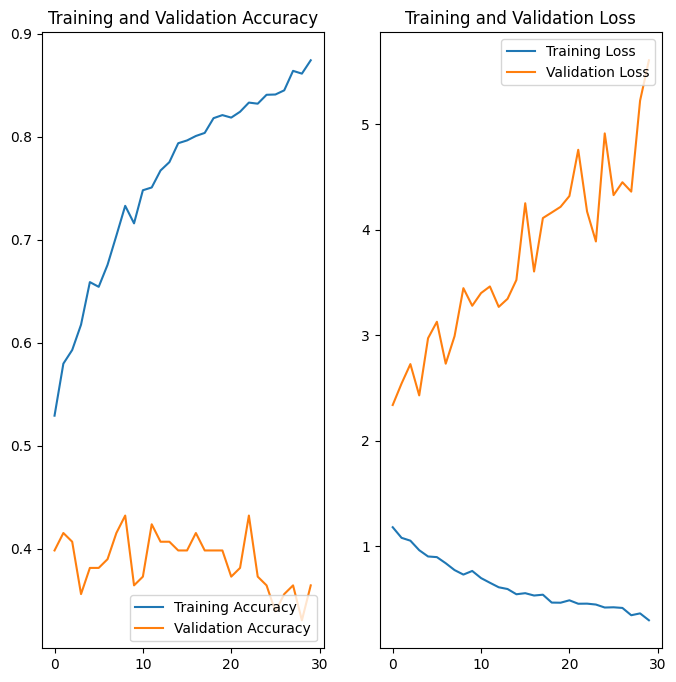

In [35]:
# Evaluate model3_aug performance
acc = model3_aug.history['accuracy']
val_acc = model3_aug.history['val_accuracy']
loss = model3_aug.history['loss']
val_loss = model3_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:
1. Formulating an alternative model without batch normalization aims to investigate prospective improvements in accuracy.
2. The ultimate model showcases mediocre underfitting.
3. The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.
4. The addition of batch normalization failed to enhance both training and validation accuracy.
5. The implementation of class rebalancing hanot y enhanced the model's performance across both training and validation datasccuracy.